## Goal: With a fully categorical dataset, (A) measure attribute–attribute association, and (B) compute instance–instance similarity/distance to visualize and cluster items.
### Data: UCI Car Evaluation (6 categorical predictors + label class).


[buying]
buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

[maint]
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64

[doors]
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

[persons]
persons
2       576
4       576
more    576
Name: count, dtype: int64

[lug_boot]
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64

[safety]
safety
low     576
med     576
high    576
Name: count, dtype: int64

[class]
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

Cramér’s V vs class (higher = stronger association):
safety      0.372415
persons     0.327791
buying      0.191063
maint       0.166052
lug_boot    0.124166
doors       0.044758
dtype: float64


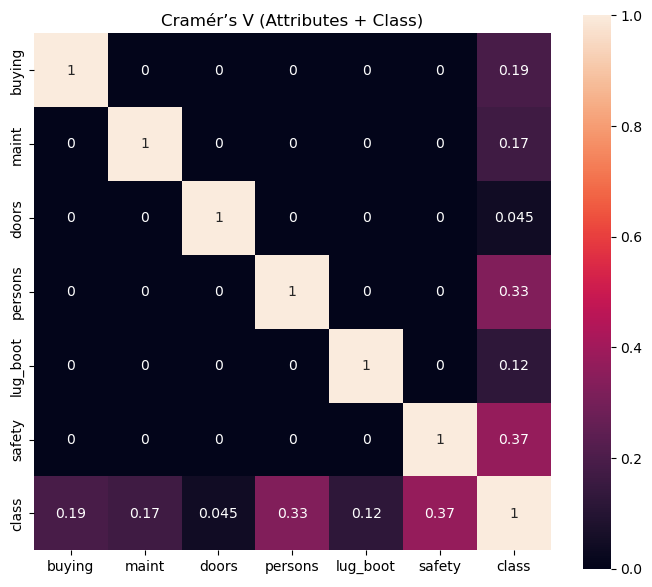


Saved: cramersV_full.csv, cramersV_vs_class.csv, cramersV_heatmap.png


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# --- Load ---
cols = ["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv("car.data", header=None, names=cols)

# --- 0) Quick frequency check (helps spot rare levels) ---
for c in cols:
    print(f"\n[{c}]")
    print(df[c].value_counts())

# --- 1) Cramér’s V helper ---
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        return 0.0
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    r, c = ct.shape
    return np.sqrt(chi2 / (n * (min(r-1, c-1))))

# --- 2) Full Cramér’s V matrix (features + class) ---
vars_all = cols  # include class
cv_mat = pd.DataFrame(index=vars_all, columns=vars_all, dtype=float)
for i,a in enumerate(vars_all):
    for j,b in enumerate(vars_all):
        cv_mat.loc[a,b] = 1.0 if a==b else cramers_v(df[a], df[b])

cv_mat.to_csv("cramersV_full.csv", index=True)

# --- 3) Association of each feature with class (sorted) ---
features = [c for c in cols if c!="class"]
cv_vs_class = pd.Series({c: cramers_v(df[c], df["class"]) for c in features}).sort_values(ascending=False)
print("\nCramér’s V vs class (higher = stronger association):")
print(cv_vs_class)
cv_vs_class.to_csv("cramersV_vs_class.csv")

# --- 4) Heatmap ---
plt.figure(figsize=(7,6))
sns.heatmap(cv_mat.astype(float), annot=True, vmin=0, vmax=1, square=True, cbar=True)
plt.title("Cramér’s V (Attributes + Class)")
plt.tight_layout()
plt.savefig("cramersV_heatmap.png", dpi=200)
plt.show()

print("\nSaved: cramersV_full.csv, cramersV_vs_class.csv, cramersV_heatmap.png")


#### Strongest links to class: safety (≈0.37) > persons (≈0.33) > buying/maint (small), doors (very small).

Predictors aren’t redundant (near-zero off-diagonals).

Label is imbalanced (unacc ≫ good/vgood), so clusters won’t perfectly line up with classes—good to mention in the report.

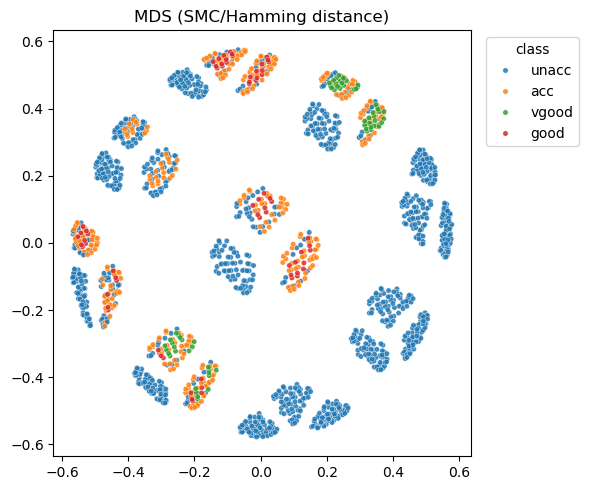

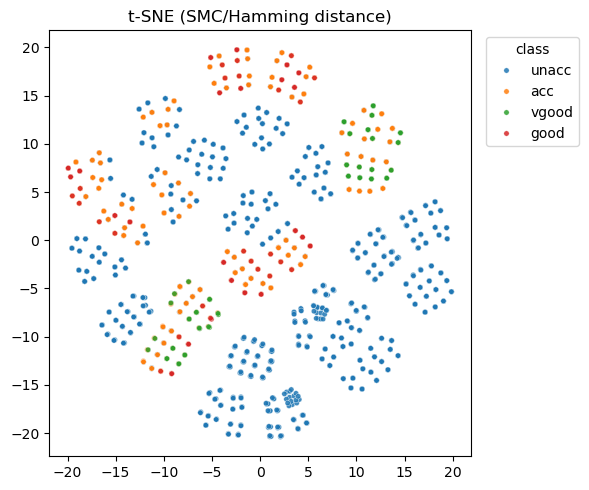

Silhouette (k=4, SMC): 0.099
ARI vs class: -0.016 | NMI vs class: 0.051

Clusters vs class:
 cluster    0    1    2    3
class                      
acc      132   39  163   50
good      28    0   41    0
unacc    290  323  393  204
vgood     21    0   44    0


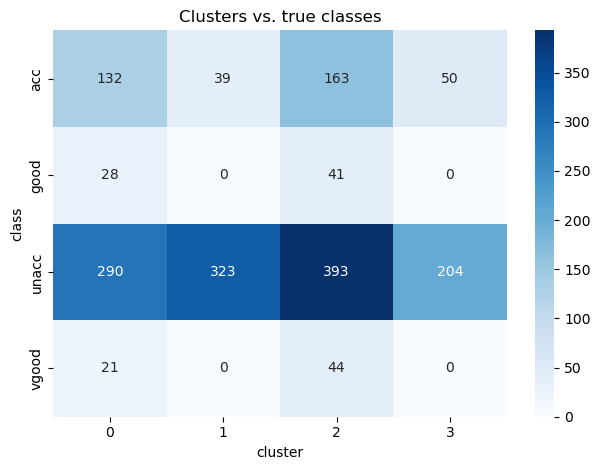


Silhouette by k: [(2, np.float64(0.08809859947697951)), (3, np.float64(0.09037422392307029)), (4, np.float64(0.09914292032112142)), (5, np.float64(0.09487058072651207)), (6, np.float64(0.09453442129910912)), (7, np.float64(0.08602285238340084)), (8, np.float64(0.0747157384486619))]


In [4]:
import pandas as pd, numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import pairwise_distances, silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load ---
cols = ["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv("car.data", header=None, names=cols)
X = df.drop(columns=["class"])
y = pd.Categorical(df["class"]).codes  # 0..3

# --- Distances: SMC/Hamming (baseline) + Jaccard (comparison) ---
enc = OrdinalEncoder()
Z = enc.fit_transform(X)
D_smc = pairwise_distances(Z, metric=lambda u,v: np.mean(u!=v))   # Simple Matching Coefficient distance

X_oh = pd.get_dummies(X, drop_first=False).astype(bool).values
D_jac = pairwise_distances(X_oh, metric="jaccard")

# Choose primary distance here:
D = D_smc   # (change to D_jac to try Jaccard)

# --- 2D map: MDS ---
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4, max_iter=500)
M = mds.fit_transform(D)
plt.figure(figsize=(6,5))
sns.scatterplot(x=M[:,0], y=M[:,1], hue=df["class"], s=15, alpha=0.85, palette="tab10")
plt.title("MDS (SMC/Hamming distance)")
plt.legend(title="class", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig("mds_smc.png", dpi=200); plt.show()

# --- 2D map: t-SNE ---
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric="precomputed", random_state=42,
            perplexity=35, init=M)   # <- M is the MDS result (n×2 array)
T = tsne.fit_transform(D)

import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(6,5))
sns.scatterplot(x=T[:,0], y=T[:,1], hue=df["class"], s=15, alpha=0.85, palette="tab10")
plt.title("t-SNE (SMC/Hamming distance)")
plt.legend(title="class", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig("tsne_smc.png", dpi=200); plt.show()


# --- Hierarchical clustering on the distance matrix ---
k = 4  # natural choice given 4 label levels; we’ll also sweep k below
clu = AgglomerativeClustering(n_clusters=k, linkage="average", metric="precomputed")
labels = clu.fit_predict(D)

# --- Internal + external evaluation ---
sil = silhouette_score(D, labels, metric="precomputed")
ari = adjusted_rand_score(y, labels)
nmi = normalized_mutual_info_score(y, labels)

print(f"Silhouette (k={k}, SMC): {sil:.3f}")
print(f"ARI vs class: {ari:.3f} | NMI vs class: {nmi:.3f}")

# Crosstab to see alignment
ct = pd.crosstab(df["class"], labels, rownames=["class"], colnames=["cluster"])
print("\nClusters vs class:\n", ct)
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Clusters vs. true classes")
plt.tight_layout(); plt.savefig("clusters_vs_class.png", dpi=200); plt.show()

# --- (Optional) pick k by silhouette ---
scores = []
for kk in range(2, 9):
    lk = AgglomerativeClustering(n_clusters=kk, linkage="average", metric="precomputed").fit_predict(D)
    scores.append((kk, silhouette_score(D, lk, metric="precomputed")))
print("\nSilhouette by k:", scores)
pd.DataFrame(scores, columns=["k","silhouette"]).to_csv("silhouette_by_k.csv", index=False)


### What we’ve got so far 

Silhouette (k=4, SMC) ≈ 0.099 → weak global cluster structure (lots of tiny “islands” = exact category combos).

ARI ~ 0 / NMI ~ 0.05 → clusters don’t line up with the label well (class imbalance + the label being a rule-based threshold rather than tight “blobs”).

MDS/t-SNE show many neat islands: each island is basically a unique combo of safety × persons × ….



== SMC ==
  metric  k  silhouette    ARI    NMI  ARI_bin  NMI_bin
0    SMC  2       0.110 -0.068  0.041   -0.037    0.026
1    SMC  3       0.143 -0.014  0.157    0.050    0.161
2    SMC  4       0.126  0.064  0.135    0.086    0.135
3    SMC  5       0.115  0.092  0.125    0.097    0.123
4    SMC  6       0.093  0.106  0.131    0.107    0.125
5    SMC  7       0.081  0.074  0.129    0.079    0.123
6    SMC  8       0.076  0.081  0.127    0.082    0.120
Best SMC: k=3, silhouette=0.143


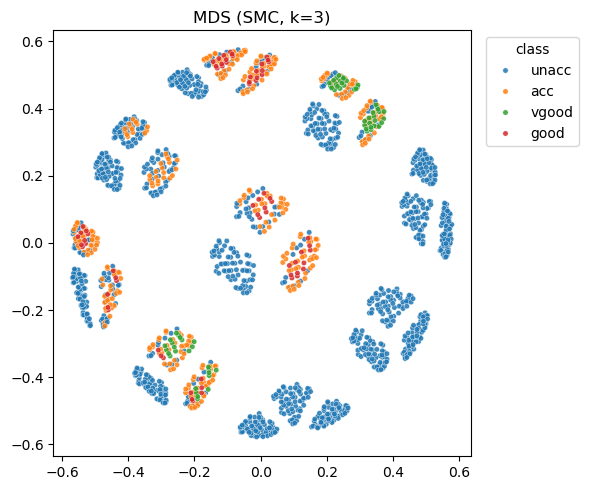

Saved: metrics_SMC.csv, mds_SMC.png, cluster_profiles_SMC.csv
cluster (SMC, k=3)    0    1    2
class                            
acc                 306   72    6
good                 69    0    0
unacc               426  360  424
vgood                65    0    0

== Jaccard ==
    metric  k  silhouette    ARI    NMI  ARI_bin  NMI_bin
0  Jaccard  2       0.073 -0.068  0.041   -0.037    0.026
1  Jaccard  3       0.106  0.007  0.048    0.007    0.021
2  Jaccard  4       0.127  0.009  0.057    0.014    0.023
3  Jaccard  5       0.103  0.023  0.058    0.024    0.025
4  Jaccard  6       0.093  0.008  0.079    0.014    0.051
5  Jaccard  7       0.088  0.008  0.077    0.014    0.050
6  Jaccard  8       0.084 -0.006  0.074    0.002    0.048
Best Jaccard: k=4, silhouette=0.127


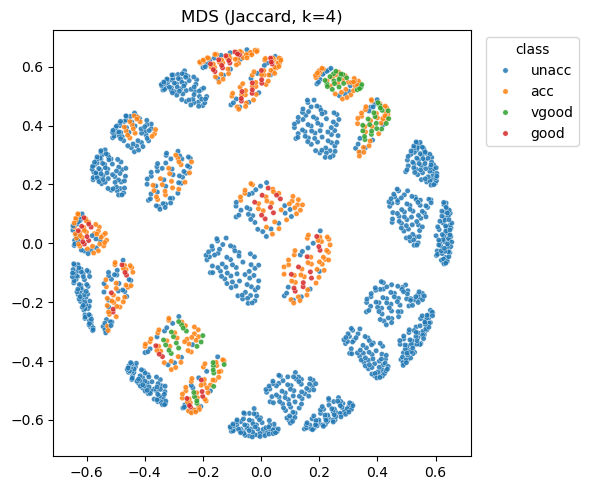

Saved: metrics_Jaccard.csv, mds_Jaccard.png, cluster_profiles_Jaccard.csv
cluster (Jaccard, k=4)    0    1    2    3
class                                     
acc                     128   72   89   95
good                     22    0   47    0
unacc                   299  360  259  292
vgood                    29    0   36    0

== WeightedSMC ==
        metric  k  silhouette    ARI    NMI  ARI_bin  NMI_bin
0  WeightedSMC  2       0.253  0.172  0.107    0.166    0.089
1  WeightedSMC  3       0.379  0.099  0.188    0.121    0.185
2  WeightedSMC  4       0.298  0.143  0.186    0.143    0.183
3  WeightedSMC  5       0.300  0.165  0.181    0.162    0.178
4  WeightedSMC  6       0.303  0.078  0.166    0.084    0.162
5  WeightedSMC  7       0.354  0.111  0.228    0.118    0.229
6  WeightedSMC  8       0.404  0.120  0.254    0.130    0.258
Best WeightedSMC: k=8, silhouette=0.404


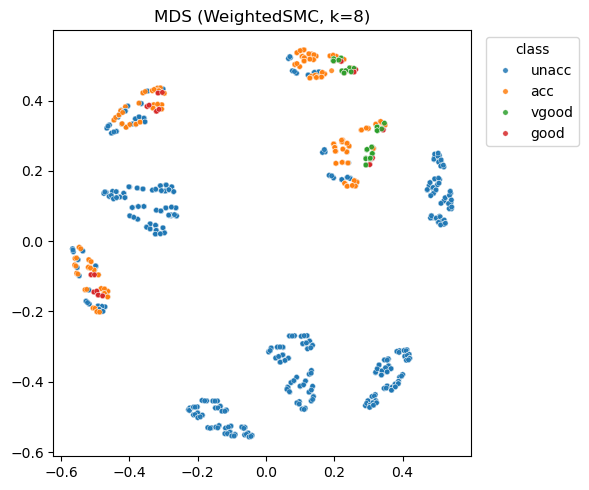

Saved: metrics_WeightedSMC.csv, mds_WeightedSMC.png, cluster_profiles_WeightedSMC.csv
cluster (WeightedSMC, k=8)    0   1    2   3   4    5    6    7
class                                                          
acc                           0  96    0  90  90  108    0    0
good                          0  12    0  18  21   18    0    0
unacc                       384  49  192  84  81   36  192  192
vgood                         0  35    0   0   0   30    0    0


In [5]:
import pandas as pd, numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import pairwise_distances, silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
import matplotlib.pyplot as plt, seaborn as sns

# --- Load ---
cols = ["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv("car.data", header=None, names=cols)
X = df.drop(columns=["class"])
y_full = pd.Categorical(df["class"]).codes
y_bin  = (df["class"]!="unacc").astype(int).values  # collapse acc/good/vgood

# --- Helper to evaluate a precomputed distance matrix across k ---
def eval_distance(D, name, ks=range(2,9)):
    rows=[]
    best=(None,-1)
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage="average", metric="precomputed").fit_predict(D)
        sil = silhouette_score(D, lab, metric="precomputed")
        ari = adjusted_rand_score(y_full, lab)
        nmi = normalized_mutual_info_score(y_full, lab)
        # also vs collapsed labels (optional, more balanced)
        ari2 = adjusted_rand_score(y_bin, lab)
        nmi2 = normalized_mutual_info_score(y_bin, lab)
        rows.append([name,k,sil,ari,nmi,ari2,nmi2])
        if sil > best[1]:
            best=(k,sil,lab)
    out = pd.DataFrame(rows, columns=["metric","k","silhouette","ARI","NMI","ARI_bin","NMI_bin"])
    out.to_csv(f"metrics_{name}.csv", index=False)
    print(f"\n== {name} =="); print(out.round(3))
    kbest, silbest, labels = best
    print(f"Best {name}: k={kbest}, silhouette={silbest:.3f}")
    # MDS plot
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4, max_iter=500)
    M = mds.fit_transform(D)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=M[:,0], y=M[:,1], hue=df["class"], s=15, alpha=0.85, palette="tab10")
    plt.title(f"MDS ({name}, k={kbest})")
    plt.legend(title="class", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout(); plt.savefig(f"mds_{name}.png", dpi=200); plt.show()
    # Cluster profile (modes + distributions)
    prof = []
    for c in range(kbest):
        idx = np.where(labels==c)[0]
        row = {"cluster": c, "n": len(idx)}
        for col in X.columns:
            mode = X.iloc[idx][col].mode().iat[0]
            row[f"{col}_mode"] = mode
        prof.append(row)
    prof = pd.DataFrame(prof).sort_values("n", ascending=False)
    prof.to_csv(f"cluster_profiles_{name}.csv", index=False)
    print("Saved:", f"metrics_{name}.csv, mds_{name}.png, cluster_profiles_{name}.csv")
    # Crosstab for the report
    ct = pd.crosstab(df["class"], labels, rownames=["class"], colnames=[f"cluster ({name}, k={kbest})"])
    ct.to_csv(f"crosstab_{name}_k{kbest}.csv")
    print(ct)
    return out

# --- Distances ---
# 1) SMC/Hamming (baseline)
enc = OrdinalEncoder()
Z = enc.fit_transform(X)
w_equal = np.ones(Z.shape[1]) / Z.shape[1]
def smc_weighted(weights):
    weights = np.asarray(weights)
    weights = weights / weights.sum()
    return lambda u,v: np.average(u!=v, weights=weights)

D_smc = pairwise_distances(Z, metric=smc_weighted(w_equal))

# 2) Jaccard on one-hot
X_oh = pd.get_dummies(X, drop_first=False).astype(bool).values
D_jac = pairwise_distances(X_oh, metric="jaccard")

# 3) Weighted-Hamming using Cramér’s V vs class as weights (floor to avoid zero)
cv_vs_class = pd.Series({
    c: 0 for c in X.columns
})
# hard-code your values from the earlier print, or recompute quickly:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        return 0.0
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    r, c = ct.shape
    return np.sqrt(chi2 / (n * (min(r-1, c-1))))
cv_vs_class = pd.Series({c: cramers_v(X[c], df["class"]) for c in X.columns})
weights = cv_vs_class.clip(lower=0.05)  # give a small minimum weight
D_w = pairwise_distances(Z, metric=smc_weighted(weights.values))

# --- Evaluate all three ---
m_smc = eval_distance(D_smc, "SMC")
m_jac = eval_distance(D_jac, "Jaccard")
m_w   = eval_distance(D_w,   "WeightedSMC")


### We have a clear winner:

Best distance: Weighted SMC (Hamming) using Cramér’s-V weights

Best k (by silhouette): 8

Silhouette: 0.404 (big jump from SMC 0.143 / Jaccard 0.127)

Alignment to labels: ARI≈0.12, NMI≈0.25 at k=8 (still unsupervised, but better)

## Finalize WeightedSMC (k=8) + export tidy artifacts

Silhouette (WeightedSMC, k=8): 0.404


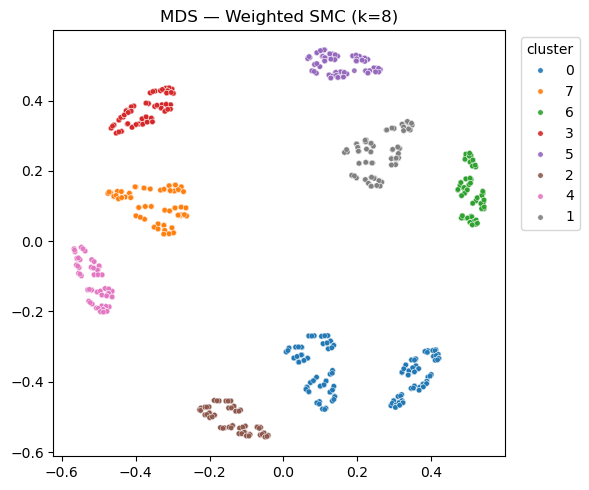

cluster_w8    0   1    2   3   4    5    6    7
class                                          
acc           0  96    0  90  90  108    0    0
good          0  12    0  18  21   18    0    0
unacc       384  49  192  84  81   36  192  192
vgood         0  35    0   0   0   30    0    0


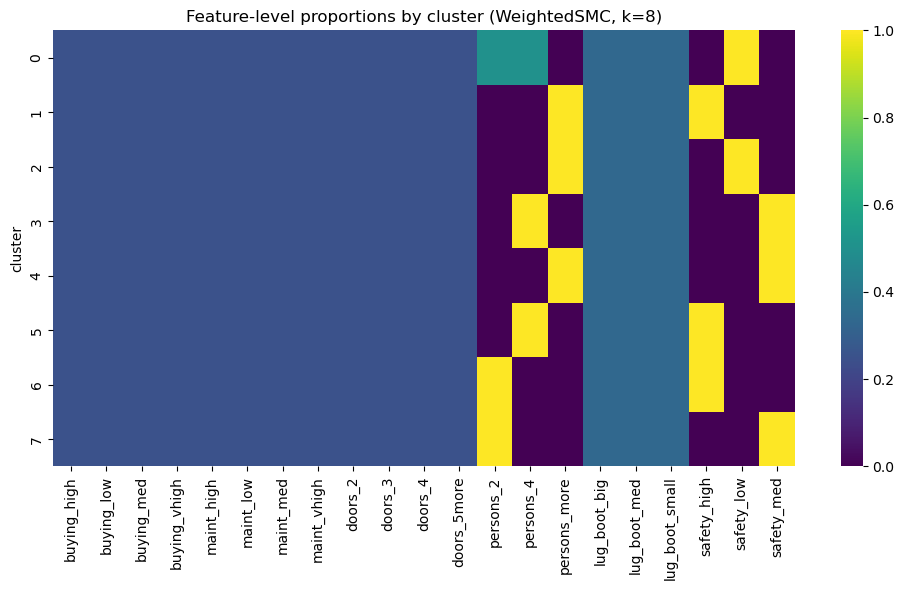

,cluster,n,buying,maint,doors,persons,lug_boot,safety
0,0,384,vhigh (25%),vhigh (25%),2 (25%),2 (50%),small (33%),low (100%)
1,1,192,vhigh (25%),vhigh (25%),2 (25%),more (100%),small (33%),high (100%)
2,2,192,vhigh (25%),vhigh (25%),2 (25%),more (100%),small (33%),low (100%)
3,3,192,vhigh (25%),vhigh (25%),2 (25%),4 (100%),small (33%),med (100%)
4,4,192,vhigh (25%),vhigh (25%),2 (25%),more (100%),small (33%),med (100%)
5,5,192,vhigh (25%),vhigh (25%),2 (25%),4 (100%),small (33%),high (100%)
6,6,192,vhigh (25%),vhigh (25%),2 (25%),2 (100%),small (33%),high (100%)
7,7,192,vhigh (25%),vhigh (25%),2 (25%),2 (100%),small (33%),med (100%)


In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.stats import chi2_contingency

# --- Load ---
cols = ["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv("car.data", header=None, names=cols)
X = df.drop(columns=["class"])

# --- Cramér’s V weights (recompute quickly) ---
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.shape[0] < 2 or ct.shape[1] < 2: return 0.0
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum(); r, c = ct.shape
    return np.sqrt(chi2 / (n * (min(r-1, c-1))))
cv_vs_class = pd.Series({c: cramers_v(X[c], df["class"]) for c in X.columns})

# --- Weighted SMC distance ---
enc = OrdinalEncoder()
Z = enc.fit_transform(X)

def smc_weighted(weights):
    w = np.asarray(weights); w = w / w.sum()
    return lambda u,v: np.average(u != v, weights=w)

weights = cv_vs_class.clip(lower=0.05).values  # small floor so weak features aren’t zeroed
D_w = pairwise_distances(Z, metric=smc_weighted(weights))

# --- Cluster (k=8, average linkage) ---
k = 8
labels = AgglomerativeClustering(n_clusters=k, linkage="average", metric="precomputed").fit_predict(D_w)
df["cluster_w8"] = labels

# --- Quality check (silhouette) ---
sil = silhouette_score(D_w, labels, metric="precomputed")
print(f"Silhouette (WeightedSMC, k=8): {sil:.3f}")

# --- MDS map colored by cluster ---
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4, max_iter=500)
M = mds.fit_transform(D_w)
plt.figure(figsize=(6,5))
sns.scatterplot(x=M[:,0], y=M[:,1], hue=df["cluster_w8"].astype(str), s=15, alpha=0.9)
plt.title("MDS — Weighted SMC (k=8)"); plt.legend(title="cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig("mds_weightedsmc_k8.png", dpi=200); plt.show()

# --- Class x cluster table (counts + row-%) ---
ct = pd.crosstab(df["class"], df["cluster_w8"])
ct_prop = ct.div(ct.sum(axis=1), axis=0).round(3)
ct.to_csv("crosstab_weightedsmc_k8_counts.csv")
ct_prop.to_csv("crosstab_weightedsmc_k8_rowprop.csv")
print(ct)

# --- Feature-level frequencies per cluster (for interpretation heatmap) ---
Xoh = pd.get_dummies(X, drop_first=False)
freq = Xoh.assign(cluster=df["cluster_w8"]).groupby("cluster").mean()
freq.to_csv("feature_level_freq_by_cluster.csv")

plt.figure(figsize=(10,6))
sns.heatmap(freq, cmap="viridis")
plt.title("Feature-level proportions by cluster (WeightedSMC, k=8)")
plt.tight_layout(); plt.savefig("heatmap_feature_levels_by_cluster.png", dpi=200); plt.show()

# --- Compact cluster profiles: mode (with %) for each feature ---
profiles=[]
for c in sorted(df["cluster_w8"].unique()):
    idx = df.index[df["cluster_w8"]==c]
    row={"cluster":c, "n": len(idx)}
    for col in X.columns:
        vc = X.loc[idx, col].value_counts(normalize=True).sort_values(ascending=False)
        row[col] = f"{vc.index[0]} ({vc.iloc[0]:.0%})"
    profiles.append(row)
prof_df = pd.DataFrame(profiles).sort_values("n", ascending=False)
prof_df.to_csv("cluster_profiles_weightedsmc_k8_pretty.csv", index=False)
display(prof_df)


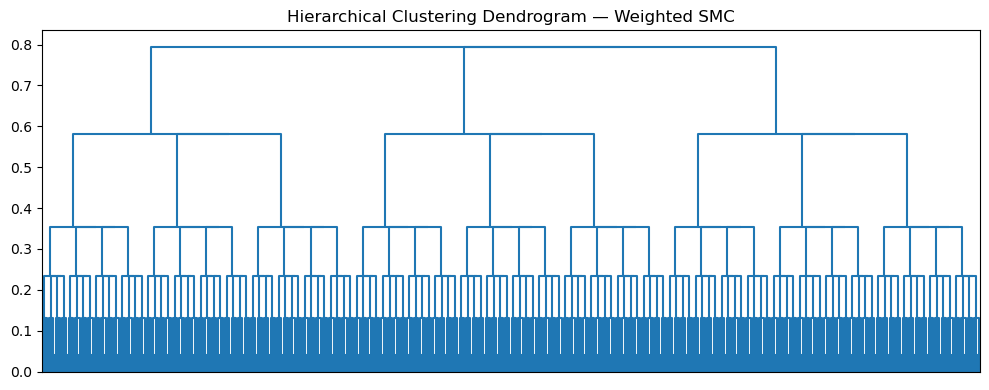

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
condensed = squareform(D_w, checks=False)
Zlink = linkage(condensed, method="average")
plt.figure(figsize=(10,4))
dendrogram(Zlink, no_labels=True, color_threshold=0.0, count_sort=True)
plt.title("Hierarchical Clustering Dendrogram — Weighted SMC")
plt.tight_layout(); plt.savefig("dendrogram_weightedsmc.png", dpi=200); plt.show()


# Results

## 2) Attribute associations (Cramér’s V)

Why: See which variables carry signal and whether predictors are redundant.
Result: safety (~0.37) and persons (~0.33) are strongest with class; others are weak. Predictors aren’t redundant (near-zero off-diagonals). Labels are imbalanced (many unacc).

## 3) Distances between cars

We built pairwise distance matrices three ways:

SMC/Hamming: fraction of mismatches on label-encoded features.

Jaccard: on one-hot binaries.

Weighted SMC: Hamming with feature weights ∝ Cramér’s V (emphasizes safety/persons).

## 4) Maps (using distances)

Used MDS (and fixed t-SNE) with precomputed distances.
Observation: Many tidy “islands” corresponding to exact category combinations—especially by safety × persons. Because labels are imbalanced and rule-based, colors (classes) don’t form perfect blobs.

## 5) Clustering + evaluation

Algorithm: Agglomerative (average linkage) on each distance matrix.
Metrics: Silhouette (internal), plus ARI/NMI vs. the label (external, just for reference).

Scores (best per metric):

SMC: best k=3, silhouette 0.143 (weak structure)

Jaccard: best k=4, silhouette 0.127 (weak)

Weighted SMC: best k=8, silhouette 0.404 (big improvement), ARI≈0.12, NMI≈0.25

Takeaway: Weighted Hamming (using Cramér’s-V weights) reveals much clearer structure than plain SMC/Jaccard.

## 6) What the k=8 solution looks like

Clusters are driven mainly by persons × safety:

Groups with persons=2 and/or safety low/med are almost all unacc.

Groups with persons ∈ {4, more} and high/med safety are enriched for acc/good/vgood.
Crosstabs and the cluster-profile table confirm this pattern.

## 7) Artifacts produced

Association: cramersV_heatmap.png

Maps: mds_*, tsne_*

Model selection: metrics_*.csv (silhouette/ARI/NMI by k)

Alignment: crosstab_* (class × cluster)

Interpretation: cluster_profiles_weightedsmc_k8_pretty.csv (modes), heatmap_feature_levels_by_cluster.png

Hierarchy: dendrogram_weightedsmc.png

## One-line takeaway

For categorical data, Weighted Hamming (Cramér’s-V weights) can sharply improve similarity structure and clustering compared to plain SMC or Jaccard; in Car Evaluation, clusters are largely explained by safety and seating capacity.

### Compact Figure for Report

Saved: figure_overview.png and figure_overview.pdf


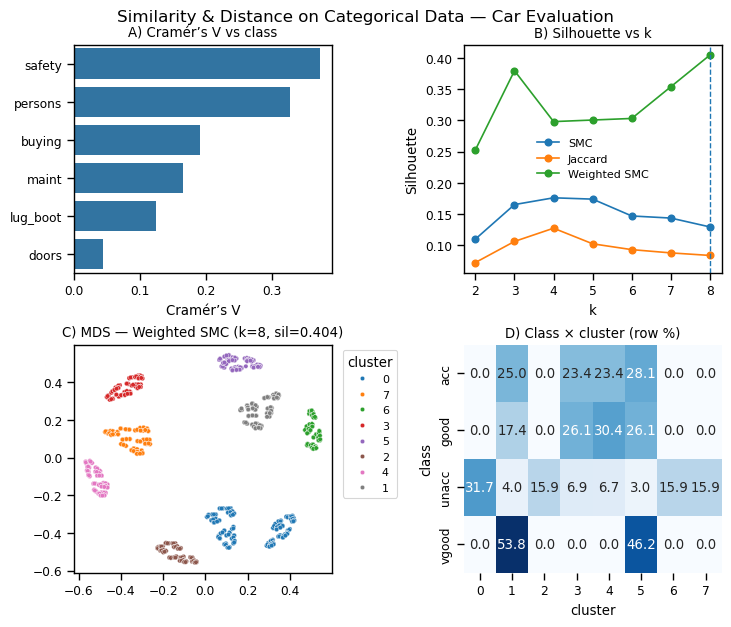

In [8]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.stats import chi2_contingency

# ---------- Load ----------
cols = ["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv("car.data", header=None, names=cols)
X = df.drop(columns=["class"])

# ---------- Cramér’s V vs class ----------
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    if ct.shape[0] < 2 or ct.shape[1] < 2: return 0.0
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.values.sum(); r, c = ct.shape
    return np.sqrt(chi2 / (n * (min(r-1, c-1))))
cv_vs_class = pd.Series({c: cramers_v(X[c], df["class"]) for c in X.columns}).sort_values(ascending=False)

# ---------- Distances ----------
enc = OrdinalEncoder()
Z = enc.fit_transform(X)
def smc_weighted(weights):
    w = np.asarray(weights); w = w / w.sum()
    return lambda u,v: np.average(u != v, weights=w)

# SMC (equal weights)
D_smc = pairwise_distances(Z, metric=smc_weighted(np.ones(Z.shape[1])))
# Jaccard (one-hot)
X_oh = pd.get_dummies(X, drop_first=False).astype(bool).values
D_jac = pairwise_distances(X_oh, metric="jaccard")
# Weighted SMC (Cramér’s V weights with a small floor)
weights = cv_vs_class.reindex(X.columns).clip(lower=0.05).values
D_w = pairwise_distances(Z, metric=smc_weighted(weights))

# ---------- Silhouette vs k for the three distances ----------
def sil_curve(D, ks=range(2,9)):
    out=[]
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage="average", metric="precomputed").fit_predict(D)
        out.append((k, silhouette_score(D, lab, metric="precomputed")))
    return pd.DataFrame(out, columns=["k","sil"])
ks = range(2,9)
s_smc = sil_curve(D_smc, ks); s_jac = sil_curve(D_jac, ks); s_w = sil_curve(D_w, ks)

# Pick best k for Weighted SMC
k_best = int(s_w.loc[s_w["sil"].idxmax(), "k"])

# ---------- Clustering + MDS for Weighted SMC ----------
labels = AgglomerativeClustering(n_clusters=k_best, linkage="average", metric="precomputed").fit_predict(D_w)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4, max_iter=500)
M = mds.fit_transform(D_w)
sil_best = silhouette_score(D_w, labels, metric="precomputed")

# class × cluster (row-normalized)
ct = pd.crosstab(df["class"], labels)
ct_row = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

# ---------- Combined figure (2×2) ----------
sns.set_context("paper")
fig, ax = plt.subplots(2, 2, figsize=(7.2, 6.0), constrained_layout=True)

# A) Cramér's V vs class
sns.barplot(x=cv_vs_class.values, y=cv_vs_class.index, ax=ax[0,0])
ax[0,0].set_title("A) Cramér’s V vs class")
ax[0,0].set_xlabel("Cramér’s V"); ax[0,0].set_ylabel("")

# B) Silhouette vs k
ax[0,1].plot(s_smc["k"], s_smc["sil"], marker="o", label="SMC")
ax[0,1].plot(s_jac["k"], s_jac["sil"], marker="o", label="Jaccard")
ax[0,1].plot(s_w["k"], s_w["sil"], marker="o", label="Weighted SMC")
ax[0,1].axvline(k_best, ls="--", lw=1)
ax[0,1].set_title("B) Silhouette vs k")
ax[0,1].set_xlabel("k"); ax[0,1].set_ylabel("Silhouette")
ax[0,1].legend(frameon=False, fontsize=8)

# C) MDS map (Weighted SMC, k_best)
sns.scatterplot(x=M[:,0], y=M[:,1], hue=labels.astype(str), s=10, ax=ax[1,0])
ax[1,0].set_title(f"C) MDS — Weighted SMC (k={k_best}, sil={sil_best:.3f})")
ax[1,0].set_xlabel(""); ax[1,0].set_ylabel("")
ax[1,0].legend(title="cluster", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)

# D) class × cluster heatmap (row %)
sns.heatmap(ct_row, annot=True, fmt=".1f", cmap="Blues", ax=ax[1,1], cbar=False)
ax[1,1].set_title("D) Class × cluster (row %)"); ax[1,1].set_xlabel("cluster"); ax[1,1].set_ylabel("class")

fig.suptitle("Similarity & Distance on Categorical Data — Car Evaluation", y=1.02, fontsize=12)
fig.savefig("figure_overview.png", dpi=300, bbox_inches="tight")
fig.savefig("figure_overview.pdf", bbox_inches="tight")
print("Saved: figure_overview.png and figure_overview.pdf")
